## Convolution AutoEncoder

References:

* https://gist.github.com/tomokishii/7ddde510edb1c4273438ba0663b26fc6
* https://github.com/pkmital/tensorflow_tutorials
* https://github.com/chiphuyen/tf-stanford-tutorials
* https://blog.dominodatalab.com/imbalanced-datasets/
* https://pgaleone.eu/neural-networks/2016/11/24/convolutional-autoencoders/
* https://pgaleone.eu/neural-networks/deep-learning/2016/12/13/convolutional-autoencoders-in-tensorflow/
* https://swarbrickjones.wordpress.com/2015/04/29/convolutional-autoencoders-in-pythontheanolasagne/
* https://gist.github.com/Newmu/a56d5446416f5ad2bbac
* https://gist.github.com/kastnerkyle/f3f67424adda343fef40
* https://github.com/Kaixhin/Autoencoders
* https://github.com/siavashk/imagenet-autoencoder
* https://siavashk.github.io/2016/02/22/autoencoder-imagenet/
* http://torch.ch/blog/2015/11/13/gan.html
* https://github.com/andreaazzini/segnet
* https://github.com/tkuanlun350/Tensorflow-SegNet
* https://github.com/shekkizh/FCN.tensorflow
* http://techtalks.tv/talks/fully-convolutional-networks-for-semantic-segmentation/61606/
* https://github.com/xiaofanglegoc/tensorflow-fcn
* https://www.robots.ox.ac.uk/~vgg/rg/papers/Dosovitskiy_Learning_to_Generate_2015_CVPR_paper.pdf
* http://stackoverflow.com/questions/36548736/tensorflow-unpoolingtensorflow/tensorflow#2169
* https://arxiv.org/pdf/1412.7062.pdf
* https://arxiv.org/pdf/1511.07122.pdf
* https://hackernoon.com/autoencoders-deep-learning-bits-1-11731e200694
* https://www.youtube.com/watch?v=eBbEDRsCmv4&t=446s
* https://www.tensorflow.org/get_started/embedding_viz
* http://rdipietro.github.io/friendly-intro-to-cross-entropy-loss/
* http://colah.github.io/posts/2014-10-Visualizing-MNIST/
* https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/autoencoder.py
* https://jmetzen.github.io/2015-11-27/vae.html
* https://github.com/tensorflow/models/blob/master/autoencoder/autoencoder_models/Autoencoder.py
* https://www.youtube.com/watch?v=H_Bi_PQWJJc
* https://www.youtube.com/watch?v=z5ZYm_wJ37c
* https://www.youtube.com/watch?v=pLC-zqttQJE
* https://www.youtube.com/watch?v=Rdpbnd0pCiI
* http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture13.pdf

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# Force to see just the first GPU
# https://devblogs.nvidia.com/parallelforall/cuda-pro-tip-control-gpu-visibility-cuda_visible_devices/
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
# Load MNIST dataset
mnist = input_data.read_data_sets("../MNIST_data/", one_hot=True)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


### Create some helper functions

In [3]:
# 2d Convolution
def conv2d(x, k_h, k_w, channels_in, channels_out, stride, act_type='relu', name="conv", viewWeights=False):
    with tf.name_scope(name):
        # Define weights
        w = tf.Variable(tf.truncated_normal([k_h,k_w, channels_in, channels_out], stddev=0.1), name="weights")
        b = tf.Variable(tf.constant(0.1, shape=[channels_out]), name="bias")    
        # Convolution
        #conv = tf.nn.conv2d(x, w, strides=[1, 1, 1, 1], padding='SAME')    
        conv = tf.nn.conv2d(x, w, strides=[1, stride, stride, 1], padding='SAME')    
                
        # Relu or sigmoid
        if act_type == 'relu':
            activation = tf.nn.relu(conv + b)
        else:
            activation = tf.sigmoid(conv + b)
        
        # Add summaries for helping debug
        tf.summary.histogram("weights", w)
        tf.summary.histogram("bias", b)
        tf.summary.histogram("activation", activation)
        
        # Visualize weights if needed
        if viewWeights == True:                        
            tf.summary.image("W_grid", put_kernels_on_grid(w,3,8), 1)            
            
        return activation

# 2d Transposed convolution (Deconvolution)
def conv2d_transpose(x, out_size, k_h, k_w, channels_in, channels_out, stride, act_type='relu', name="deconv"):
    with tf.name_scope(name):
        # Define weights (Notice that out/in channels are swapped on transposed conv)
        w = tf.Variable(tf.truncated_normal([k_h,k_w, channels_out, channels_in], stddev=0.1), name="weights")
        b = tf.Variable(tf.constant(0.1, shape=[channels_out]), name="bias")    
        
        # Image output shape
        shape4D = [tf.shape(x)[0], out_size[0], out_size[1], channels_out]
        # Deconvolution (Transposed convolution)
        conv = tf.nn.conv2d_transpose(x, w, output_shape=shape4D, strides=[1, stride, stride, 1], padding='SAME')                
        
        # Relu or sigmoid
        if act_type == 'relu':
            activation = tf.nn.relu(conv + b)
        else:
            activation = tf.sigmoid(conv + b)
        
        # Add summaries for helping debug
        tf.summary.histogram("weights", w)
        tf.summary.histogram("bias", b)
        tf.summary.histogram("activation", activation)                
            
        return activation    

def max_pool(x, k_h, k_w, S, name="maxpool"):
    with tf.name_scope(name):
        return tf.nn.max_pool(x, ksize=[1, k_h, k_w, 1],strides=[1, S, S, 1], padding='SAME')


def fc_layer(x, channels_in, channels_out, name="fc"):
    with tf.name_scope(name):
        w = tf.Variable(tf.truncated_normal([channels_in, channels_out], stddev=0.1), name="weights")
        b = tf.Variable(tf.constant(0.1, shape=[channels_out]), name="bias")    
        activation = tf.nn.relu(tf.matmul(x, w) + b)
        # Add summaries for helping debug
        tf.summary.histogram("weights", w)
        tf.summary.histogram("bias", b)
        tf.summary.histogram("activation", activation)
        return activation

### Define Model

In [4]:
# Input placeholders
x = tf.placeholder(tf.float32, [None, 784])

# Reshape to MNIST image dimensions 28x28x1
x_image = tf.reshape(x, [-1, 28, 28, 1])

# K_y,K_x,in_depth,out_depth,stride
conv1_out = conv2d(x_image, 3, 3, 1, 16, 1, act_type='relu', name="conv1")        
pool1_out = max_pool(conv1_out, 2, 2, 2, "pool1")        
conv2_out = conv2d(pool1_out, 3, 3, 16, 8, 1, act_type='relu', name="conv2")        
pool2_out = max_pool(conv2_out, 2, 2, 2, "pool2")        
conv3_out = conv2d(pool2_out, 3, 3, 8, 8, 1, act_type='relu', name="conv3")    
pool3_out = max_pool(conv3_out, 2, 2, 2, "pool3")

# at this point the representation is (8, 4, 4) i.e. 128-dimensional
# Decoding phase    
conv_t1_out = conv2d_transpose(pool3_out, (7, 7), 3, 3, 8, 8, 2, act_type='relu', name="dconv1")        
conv_t2_out = conv2d_transpose(conv_t1_out, (14, 14), 3, 3, 8, 8, 2, act_type='relu', name="dconv2")        
conv_t3_out = conv2d_transpose(conv_t2_out, (28, 28), 3, 3, 8, 16, 2, act_type='relu', name="dconv3")        

decoded_img = conv2d(conv_t3_out, 3, 3, 16, 1, 1,act_type='sigmoid',name="conv4")        

# Convert spatial result to a vector in order to match with input "x" shape
decoded = tf.reshape(decoded_img, [-1, 784])

# Reshape for summary
decoded_img_sumary = tf.reshape(decoded_img, [-1, 28, 28, 1])

### Define loss and solver

In [5]:
# Binary cross-entropy
with tf.name_scope("cross_entropy"):
    cross_entropy = -1. *x *tf.log(decoded) - (1. - x) *tf.log(1. - decoded)
    loss = tf.reduce_mean(cross_entropy)
    # Can also use l2 loss but you need to decrease the learning rate
    #loss = tf.nn.l2_loss(x-decoded)

# Solver configuration
with tf.name_scope("Solver"):
    train_step = tf.train.AdagradOptimizer(0.1).minimize(loss)  


### Add some tensors to tensorboard

In [6]:
# Add summary for loss, input images, output images
tf.summary.scalar("loss", loss)
tf.summary.image("input", x_image, 10)
tf.summary.image("output", decoded_img_sumary, 10)

fc1_out_size = 8*4*4
embedding = tf.Variable(tf.zeros([128, fc1_out_size]), name="test_embedding")
assignment = embedding.assign(tf.reshape(pool3_out, [128, fc1_out_size]))
saver = tf.train.Saver()

### Define graph

In [7]:
init = tf.global_variables_initializer()

# Avoid allocating the whole memory
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

#sess = tf.Session()
sess.run(init)

merged_summary = tf.summary.merge_all()
writer = tf.summary.FileWriter("/tmp/conv_autoencoder/1")
writer.add_graph(sess.graph)

### Training

In [8]:
# Train
with sess:    
    print('Training...')
    for i in range(10001):
        batch_xs, _ = mnist.train.next_batch(128)
        train_step.run({x: batch_xs})
        if i % 1000 == 0:
            train_loss= loss.eval({x: batch_xs})
            print('  step, loss = %6d: %6.3f' % (i, train_loss))
        
        # Dump summary (Avoid dump every iteration)
        if i % 100 == 0:
            s = sess.run(merged_summary, feed_dict={x:batch_xs})
            writer.add_summary(s,i)
            
            # Save embedding (for PCA, TSNE)
            sess.run(assignment, feed_dict={x: batch_xs})
            saver.save(sess, os.path.join("/tmp/conv_autoencoder/", "model.ckpt"), i)

    # generate decoded image with test data        
    #decoded_imgs = decoded.eval(feed_dict={x:mnist.test.images})
    #print('loss (test) = ', loss.eval(feed_dict={x:mnist.test.images}))
    # Avoid restarting my work PC (Avoid loading the whole validation batch)
    batch_xs_val, _ = mnist.test.next_batch(128)
    decoded_imgs = decoded.eval(feed_dict={x:batch_xs_val})
    print('loss (test) = ', loss.eval(feed_dict={x:batch_xs_val}))    

Training...
  step, loss =      0:  0.600
  step, loss =   1000:  0.180
  step, loss =   2000:  0.141
  step, loss =   3000:  0.131
  step, loss =   4000:  0.124
  step, loss =   5000:  0.120
  step, loss =   6000:  0.118
  step, loss =   7000:  0.120
  step, loss =   8000:  0.113
  step, loss =   9000:  0.113
  step, loss =  10000:  0.116
loss (test) =  0.109717


### Display Results

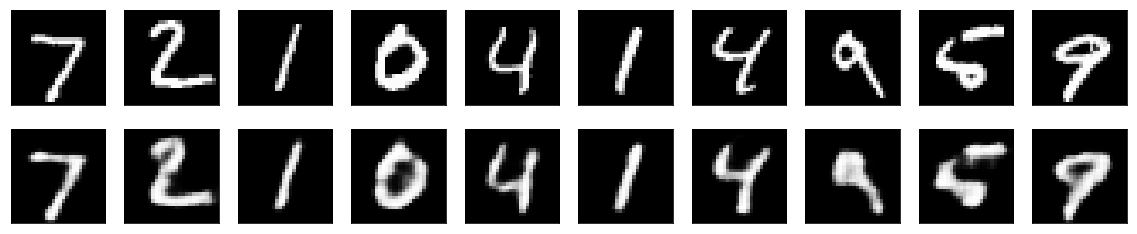

In [9]:
#x_test = mnist.test.images
x_test = batch_xs_val
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()
#plt.savefig('mnist_ae2.png')